In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [91]:
#events_raw = scipy.io.loadmat("../data/desk/events.txt")
events = np.loadtxt("../data/desk/events.txt", max_rows=100000)

In [92]:
# events_rel = events_raw["events"]
# events = np.zeros(events_rel.shape)
# events[:,0] = events_rel[:,3]
# events[:,1:] = events_rel[:,:3]

In [103]:
events[0]

array([6.999e-06, 1.630e+02, 1.170e+02, 1.000e+00])

In [94]:
time_range = [0.0, 1.0]
idx_range = [np.searchsorted(events[:,0], time_range[0]), np.searchsorted(events[:,0], time_range[1])]
events = events[idx_range[0]:idx_range[1], :]

In [95]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [96]:
def img_from_events(events):
    img_height = int(events[:,2].max()+1)
    img_width = int(events[:,1].max()+1)
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img

In [97]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

In [98]:
t_start = events[0, 0]

In [99]:
last_time = np.zeros(shape)
time_diff_dict = {}
dist = 3
warped_shape = (180, 200)
bins = np.linspace(0, 900, 80)
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist:
        continue
    
    if last_time[y, x+dist] != 0:
        speed = dist/(e[0] - last_time[y, x+dist])
#         i = np.digitize(speed, bins)
#         if i>=len(bins):
#             continue
#         speed = bins[i]
        warp_pos_x = int(x + (e[0] - t_start) * speed)
        if warp_pos_x >= warped_shape[1]:
            continue
        if (y, warp_pos_x) in time_diff_dict:
            time_diff_dict[y, warp_pos_x].append(speed)
        else:
            time_diff_dict[y, warp_pos_x] = [speed]

In [100]:
warped_img = np.zeros(warped_shape)
for k in time_diff_dict:
    y = k[0]
    x = k[1]
    if len(time_diff_dict[k]) <= 1:
        continue
    warped_img[y, x] = np.median(time_diff_dict[k])

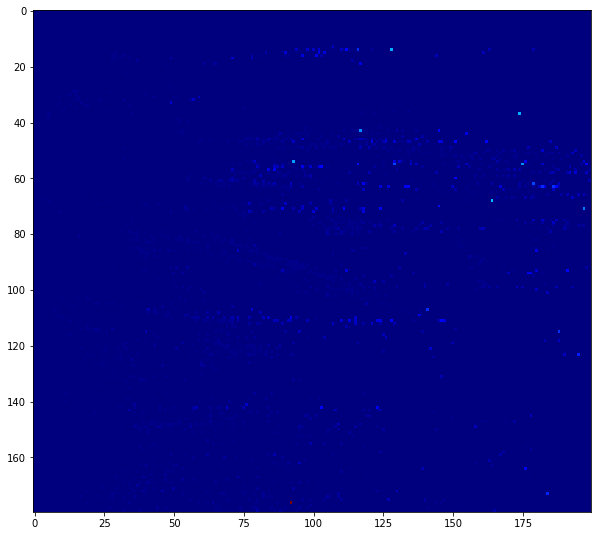

In [101]:
%matplotlib inline
#time_diff_fil = np.ma.masked_where(time_difference < 2, time_difference)
plt.figure(figsize=(10, 10))
plt.imshow(warped_img, cmap="jet", interpolation="none")

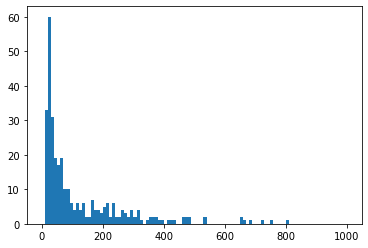

In [80]:
plt.hist(warped_img.flatten(), 100, range=(1, 1000));

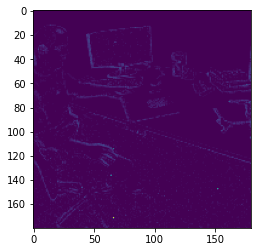

In [81]:
plt.imshow(img_from_events(events))

In [82]:
conv_shape = (3, 3)
conv_stride = conv_shape
result_shape = (int(warped_img.shape[0]/conv_stride[0])+1, int(warped_img.shape[1]/conv_stride[1])+1)
dict_px = {} 
dict_t = {}
for x in range(warped_img.shape[1]):
    for y in range(warped_img.shape[0]):
        if warped_img[y, x] == 0:
            continue

        x_c = int(x / conv_stride[0])
        y_c = int(y / conv_stride[1])

        if (y_c, x_c) in dict_px:
            dict_px[y_c, x_c].append(warped_img[y, x])
        else:
            dict_px[y_c, x_c] = [warped_img[y, x]]

In [63]:
time_diff_med = np.zeros(result_shape)
for k in dict_px:
    y = k[0]
    x = k[1]
    if len(dict_px[k]) <= 2:
        continue
    time_diff_med[y, x] = np.median(dict_px[k])

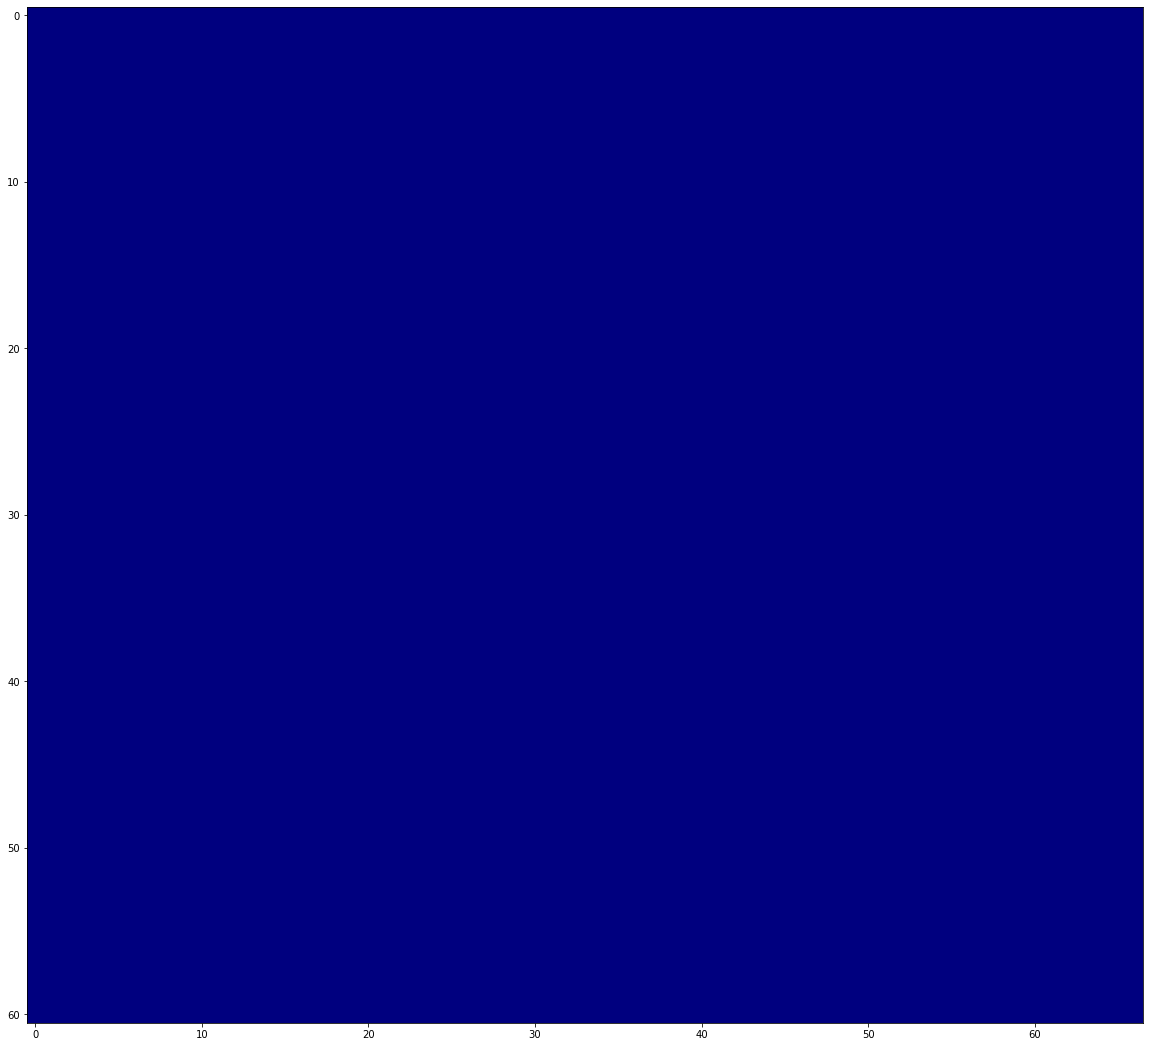

In [64]:
%matplotlib inline
plt.figure(figsize=(20, 20))
m = plt.imshow(time_diff_med, cmap="jet")
#plt.colorbar(mappable=m)

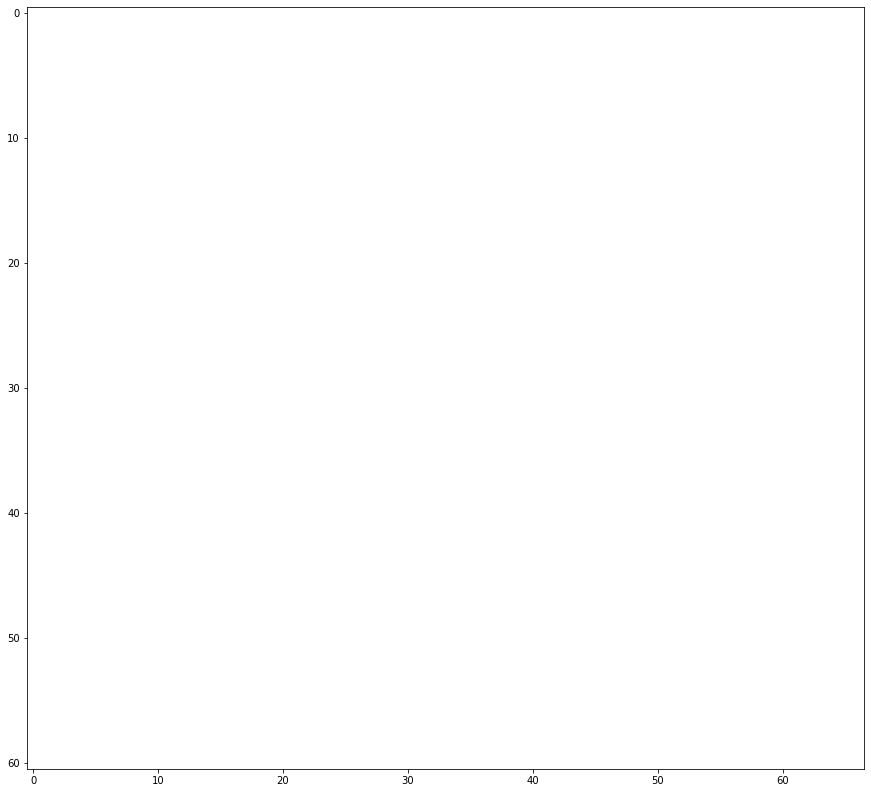

In [65]:
time_diff_med_m = np.ma.masked_where(time_diff_med<=0, time_diff_med)
u = time_diff_med_m

v = 0.2901460156636141
f = 335.419462958

d = np.divide(f, u, where=u>0.0) * v

plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r", vmin=0, interpolation="none")
#plt.colorbar(m)

In [66]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x] or d.data[y, x] > 30:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [67]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [68]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r", vmin=0, vmax=3)
set_axes_equal(ax)
ax.set_zlim3d([0, 3])
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Conv on the input spikes to reduce variability for fast motions

We can see above that for fast motions, the velocity varies a lot, making the warped image very "spread out" compared to slower motion. A convolution on the input spikes may help mitigating this effect

In [ ]:
#perform the convolution
shape = (180, 180)
conv_stride = (2, 2)
conv_shape = (2, 2)
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
spk_count = np.zeros(result_shape)
time_count = np.zeros(result_shape)
spk_thresh = conv_shape[0]*conv_shape[1]*0.5
events_conv = []
for e in events:
    if e[3] == 1:
        continue
    x = int(e[1])
    y = int(e[2])

    x_c = int(x / conv_stride[0])
    y_c = int(y / conv_stride[1])

    spk_count[y_c, x_c] += 1
    time_count[y_c, x_c] += e[0]
    
    if spk_count[y_c, x_c] >= spk_thresh:
        time_avg = time_count[y_c, x_c] / spk_count[y_c, x_c]
        events_conv.append([time_avg, x_c, y_c, e[3]])
        spk_count[y_c, x_c] = 0
        time_count[y_c, x_c] = 0
events_conv = np.array(events_conv)

In [ ]:
shape = result_shape

In [ ]:
t_start = events[0, 0]

In [ ]:
last_time = np.zeros(shape)
time_diff_dict = {}
dist = 7
warped_shape = (int(180/conv_stride[0]), 600)
for e in events_conv:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist:
        continue
    
    if last_time[y, x+dist] != 0:
        if e[0] - last_time[y, x+dist] <= 0:
            continue
        speed = dist/(e[0] - last_time[y, x+dist])
        warp_pos_x = int(x + (e[0] - t_start) * speed)
        if warp_pos_x >= warped_shape[1]:
            continue
        if (y, warp_pos_x) in time_diff_dict:
            time_diff_dict[y, warp_pos_x].append(speed)
        else:
            time_diff_dict[y, warp_pos_x] = [speed]

In [ ]:
%matplotlib inline
plt.imshow(img_from_events(events_conv))

In [ ]:
warped_img = np.zeros(warped_shape)
for k in time_diff_dict:
    y = k[0]
    x = k[1]
    if len(time_diff_dict[k]) <= 2:
        continue
    warped_img[y, x] = np.median(time_diff_dict[k])

In [ ]:
#time_diff_fil = np.ma.masked_where(time_difference < 2, time_difference)
plt.figure(figsize=(20, 20))
plt.imshow(warped_img, cmap="jet")

In [ ]:
plt.hist(warped_img.flatten(), 100, range=(0.1, 1000));